Your Goal: The goal of this competition is to predict the price of used cars based on various attributes.

Root Mean Squared Error (RMSE)
Submissions are scored on the root mean squared error. RMSE is defined as:

RMSE=(1N∑i=1N(yi−yˆi)2)12

where yˆi
 is the predicted value and yi
 is the original value for each instance i
.

Submission File
For each id in the test set, you must predict the price of the car. The file should contain a header and have the following format:

## Import and Load Data.

In [1]:
# import libraries.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error # Remember to take the root of the result.
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
import optuna

In [2]:
# Building a function that preprocess the data.
def wrangle(filepath):
    
    # read file to dataframe.
    df = pd.read_csv(filepath, index_col="id")
    
    # Dropping the clean_title column.
    df = df.drop(columns=["clean_title"])
    
    # interior color
    df["int_col"]= df["int_col"].str.lower().str.split("[/,  ]").apply(lambda x: x[-1])
    
    # exterior color.
    df["ext_col"] = df["ext_col"].str.lower().str.split("[/, -,  ]").apply(lambda x: x[-1])
    
    # Creating new features.
    df["hp"] = df["engine"].str.lower().str.split("hp").apply(lambda x: np.nan if len(x) == 1 else x[0])
    # convert the hp column to an intger datatype.
    df["hp"] = df["hp"].astype(float)
    # getting the cylinder engine.
    df["cylinder_engine"] = df["engine"].str.split().apply(lambda x: 
                               next((
                                   value for value in x if isinstance(value, str) and value.isdigit()),
                                   np.nan)
                              )
    df["cylinder_engine"] = df["cylinder_engine"].astype(float)
    df.loc[df["cylinder_engine"] == 120, "cylinder_engine"] = np.nan
    # getting the len of description of the engine.
    df["des_lenght"] = df["engine"].str.split().apply(lambda x: len(x))
    
    df.loc[df["transmission"] == "A/T", "transmission"] = "Automatic"
    
    # Get the fuel-type from the engine information.
    engine_fuel = df["engine"].str.lower().str.split("cylinder engine").apply(lambda x: np.nan if len(x) == 1 else x[-1]).str.strip()#.value_counts()
    
    # Fill the engine-fuel to the fuel_type column.
    df["fuel_type"] = df["fuel_type"].str.lower().fillna(engine_fuel)
    
    df["transmission"] = df["transmission"].str.lower().str.replace("a/t", "automatic").str.replace("at$", "automatic", regex=True)
    
    # Dealing with the inconsistence in the data.
    # changing the e85 flex fuel to flex.
    df.loc[df["fuel_type"] == "e85 flex fuel", "fuel_type"] = "flex"
    df.loc[df["fuel_type"] == "diesel fuel", "fuel_type"] = "diesel"
    df.loc[df["fuel_type"] == "gasoline fuel", "fuel_type"] = "gasoline"
    df.loc[df["fuel_type"] == "flex fuel capability", "fuel_type"] = "flex"
    
    
    return df

In [3]:
filepath = "/kaggle/input/playground-series-s4e9/train.csv"
df = wrangle(filepath)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,hp,cylinder_engine,des_lenght
id,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,automatic,yellow,gray,None reported,4200,172.0,4.0,7
1,Lincoln,LS V8,2002,143250,gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,automatic,silver,beige,At least 1 accident or damage reported,4999,252.0,8.0,7
2,Chevrolet,Silverado 2500 LT,2002,136731,flex,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,automatic,blue,gray,None reported,13900,320.0,8.0,8
3,Genesis,G90 5.0 Ultimate,2017,19500,gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,transmission w/dual shift mode,black,black,None reported,45000,420.0,8.0,7
4,Mercedes-Benz,Metris Base,2021,7388,gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-speed automatic,black,beige,None reported,97500,208.0,4.0,7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   brand            188533 non-null  object 
 1   model            188533 non-null  object 
 2   model_year       188533 non-null  int64  
 3   milage           188533 non-null  int64  
 4   fuel_type        183501 non-null  object 
 5   engine           188533 non-null  object 
 6   transmission     188533 non-null  object 
 7   ext_col          188533 non-null  object 
 8   int_col          188533 non-null  object 
 9   accident         186081 non-null  object 
 10  price            188533 non-null  int64  
 11  hp               155274 non-null  float64
 12  cylinder_engine  101361 non-null  float64
 13  des_lenght       188533 non-null  int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 21.6+ MB


In [5]:
df.shape

(188533, 14)

In [6]:
df.isnull().sum()

brand                  0
model                  0
model_year             0
milage                 0
fuel_type           5032
engine                 0
transmission           0
ext_col                0
int_col                0
accident            2452
price                  0
hp                 33259
cylinder_engine    87172
des_lenght             0
dtype: int64

In [7]:
df.describe()

,model_year,milage,price,hp,cylinder_engine,des_lenght
count,188533.000000,188533.000000,1.885330e+05,155274.000000,101361.000000,188533.000000
mean,2015.829998,65705.295174,4.387802e+04,343.263856,6.556368,6.733394
std,5.660967,49798.158076,7.881952e+04,114.734210,1.868492,1.207792
min,1974.000000,100.000000,2.000000e+03,70.000000,3.000000,1.000000
25%,2013.000000,24115.000000,1.700000e+04,263.000000,4.000000,7.000000
50%,2017.000000,57785.000000,3.082500e+04,329.000000,8.000000,7.000000
75%,2020.000000,95400.000000,4.990000e+04,416.000000,8.000000,7.000000
max,2024.000000,405000.000000,2.954083e+06,1020.000000,12.000000,9.000000


In [8]:
df.nunique().sort_values() # the clean_title contain only a value through out the dataset.

accident              2
cylinder_engine       7
fuel_type             9
des_lenght            9
model_year           34
transmission         40
brand                57
ext_col              73
int_col              83
hp                  348
engine             1117
price              1569
model              1897
milage             6651
dtype: int64

## EDA

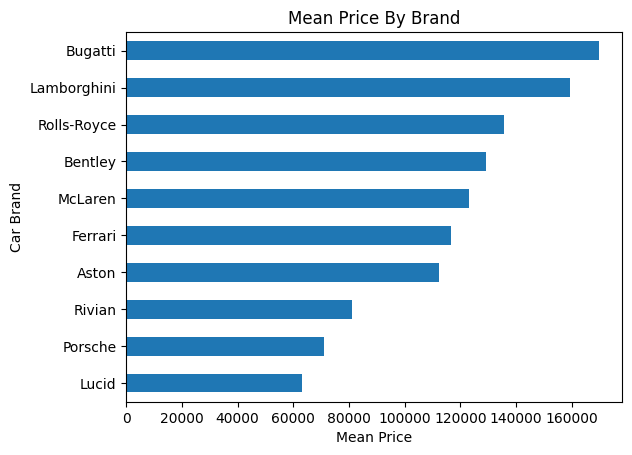

In [9]:
n_top = 10
brand_price = df["price"].groupby(df["brand"]).mean()
brand_price.sort_values().tail(n_top).plot(kind="barh")
plt.ylabel("Car Brand")
plt.xlabel("Mean Price")
plt.title("Mean Price By Brand");

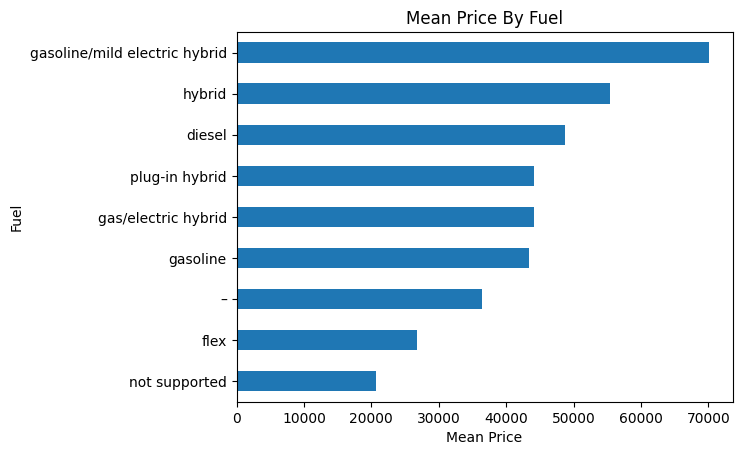

In [10]:
df["price"].groupby(df["fuel_type"]).mean().sort_values().tail(10).plot(kind="barh")
plt.ylabel("Fuel")
plt.xlabel("Mean Price")
plt.title("Mean Price By Fuel");

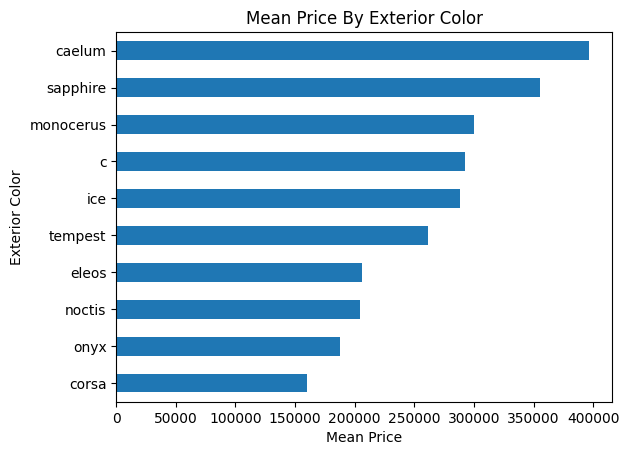

In [11]:
df["price"].groupby(df["ext_col"]).mean().sort_values().tail(10).plot(kind="barh")
plt.ylabel("Exterior Color")
plt.xlabel("Mean Price")
plt.title("Mean Price By Exterior Color");

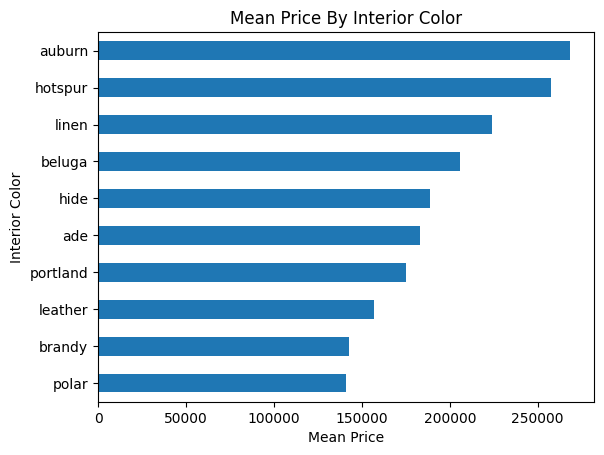

In [12]:
df["price"].groupby(df["int_col"]).mean().sort_values().tail(10).plot(kind="barh")
plt.ylabel("Interior Color")
plt.xlabel("Mean Price")
plt.title("Mean Price By Interior Color");

## Split the data.

In [13]:
target = "price"
X = df.drop(columns=target)
y= df[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((150826, 13), (150826,))

## Model

### Baseline Model.

In [15]:
y_pred = [y_train.mean()] * len(y_train)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

79845.61699591158

In [16]:
import time

In [17]:
def model(models):
    score_dict = {}
    print("Model Fitting in Progress.")
    for al in models:
        model = make_pipeline(
            OrdinalEncoder(),
            SimpleImputer(),
            MinMaxScaler(),
            al
        )
        start = time.time()
        model.fit(X_train, y_train)
        train_time_lapse = time.time() - start
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        train_mse= mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        result = [train_rmse, test_rmse, train_time_lapse]
        al_name = list(model.named_steps.keys())[-1]
        score_dict[al_name] = result
        
    score_df = pd.DataFrame(score_dict).T
    print("Models Fitted")
        
    return score_df

In [18]:
models = [CatBoostRegressor(verbose=0, random_state=42), 
         XGBRegressor(random_state=42), 
         LGBMRegressor(verbose=-1, random_state=42)]
modelling = model(models)
modelling

Model Fitting in Progress.
Models Fitted


,0,1,2
catboostregressor,64519.387099,69011.479999,15.797134
xgbregressor,59108.137220,70781.726106,3.253391
lgbmregressor,70168.444315,68384.662883,2.577092


In [19]:
test = wrangle("/kaggle/input/playground-series-s4e9/test.csv")

In [20]:
model = make_pipeline(
            OrdinalEncoder(),
            SimpleImputer(),
            MinMaxScaler(),
            LGBMRegressor(verbose=-1, random_state=42)
        )
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['brand', 'model', 'fuel_type', 'engine',
                                      'transmission', 'ext_col', 'int_col',
                                      'accident'],
                                mapping=[{'col': 'brand',
                                          'data_type': dtype('O'),
                                          'mapping': Mercedes-Benz     1
Nissan            2
Ford              3
Hyundai           4
Dodge             5
Lexus             6
BMW               7
INFINITI          8
Porsche           9
Chevrolet        10
Land             11
Toyota           12
RAM              13
Volkswagen       14
Lincoln          15
GMC              16
Alfa             17
Honda            18
Jeep             19
Subaru           20
Lamb...
                                          'data_type': dtype('O'),
                                          'mapping': black        1
gray         2
beige        3
–            4
white        5
            ..
auburn      80
cashmere    81
pewter      82
sport       83
NaN         -2
Length: 84, dtype: int64},
                                         {'col': 'accident',
                                          'data_type': dtype('O'),
                                          'mapping': At least 1 accident or damage reported    1
None reported                             2
NaN                                       3
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('minmaxscaler', MinMaxScaler()),
                ('lgbmregressor', LGBMRegressor(random_state=42, verbose=-1))])

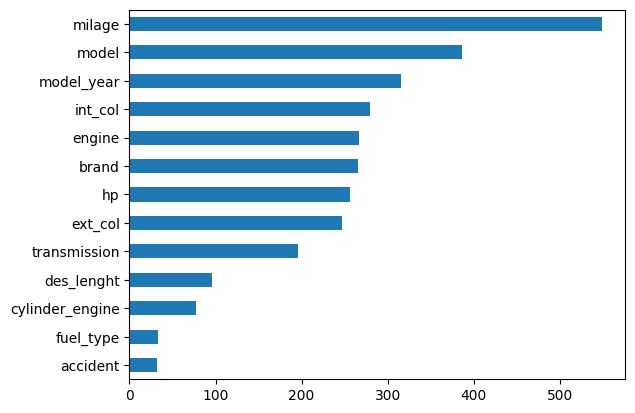

In [21]:
imp = model.named_steps["lgbmregressor"].feature_importances_
feat = X.columns
pd.Series(imp, index=feat).sort_values().plot(kind="barh");

In [22]:
pred = model.predict(test)
pd.DataFrame(pred, index= test.index).to_csv("lgbmversion1")